# Step 1: Network Filtering and Processing
---
### This the first of five steps to running BikewaySim
1. __Process network spatial data into a routable network graph format__
2. Reconcile networks into one through node and link overlap conflation
3. Create final network graph and calculate link costs
4. Create OD tables
5. Run BikewaySim

Run this code block by block to convert a road network shapefile in ESRI Shapefile, GeoJSON, or GeoPackage format into a routable and conflated network graph to use in BikewaySim.

Note that three networks were used in this project. While code to obtain OSM GeoJSONs has been included with osm_processing notebook, the ABM and HERE networks need to be sourced from the Atlanta Regional Commission and HERE respectively. You can run most of this code with only OSM data, but you can skip Step 2.

#### Import/install the following packages:

In [1]:
from pathlib import Path
import geopandas as gpd

#### Import Network Filter Module:

In [2]:
from network_filter import *

#### General Settings Dictionary

In [3]:
settings = {
    'output_fp': Path.home() / Path('Documents/BikewaySimData'), #where filtered network files will output
    'crs': "EPSG:2240", # project all spatial data to this CRS
    'studyarea_fp': Path.home() / Path('Documents/BikewaySimData/bikewaysim_study_area/bikewaysim_study_area.shp'),
    'studyarea_name': 'bikewaysim',
    'studyarea_layer': None, #replace with study area layer name if file is gpkg or gdb
    'use_bbox': False # use bounding box instead of studyarea polygon boundaries as mask for importing links
}

#other filepaths
#studyareafp = r'base_shapefiles/studyareas/atl_district5.gpkg'
#studyarea_name = 'atl_district5'
#studyareafp = r'base_shapefiles/studyareas/ITS4US_StudyBoundary.shp'
#studyarea_name = 'its4us'
#studyareafp = r'base_shapefiles/studyareas/district5.geojson'
#studyarea_name = 'district5'
#studyareafp = r'base_shapefiles/studyareas/marta.gpkg'
#studyarea_name = 'marta'

#### Import study area:
Specify what area you want to mask the network data by. Only network links that are partially or fully within the study area will be imported. Note: network links are NOT clipped (because this cuts off nodes).

The area of the bikewaysim study area is 12.4 square miles.


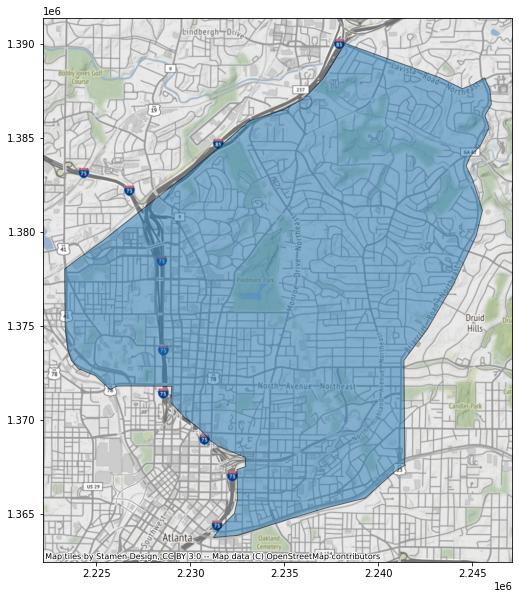

In [4]:
settings['studyarea'] = import_study_area(settings)

## Network Data Filepaths:
Use this to specify the filepath of your network's links and/or nodes. Only links are required because nodes can be created from the links.

In [5]:
studyarea_name = settings['studyarea_name']
osmfp = Path.home() / Path(f'Documents/BikewaySimData/osm/{studyarea_name}.gpkg')
#abmfp = r'base_shapefiles/arc/ABM2020-TIP20-2020-150kShapefiles-outputs.gdb'
#abmnodesfp = r'base_shapefiles/arc/ABM2020-TIP20-2020-150kShapefiles-outputs.gdb'
#herefp = r'base_shapefiles/here/Streets.shp'

## OpenStreetMap (OSM) Filtering
OSM is an open-source mapping project (see www.openstreetmap.org)

OSM network data can be downloaded using the "osm_processing.ipynb" Jupyter Notebook.

In [6]:
osm = {
       "network_name": 'osm', # name for network
       "links_fp": osmfp, #filepath for the links
       "links_layer":"links", # layer name for links if gpkg or gdb
       "nodes_fp":osmfp, # if there is not a nodes file put None
       "nodes_layer":"nodes", # layer name for nodes if gpkg or gdb
       "nodes_id": "osmid", # column name of
       "A": "A",
       "B": "B",
       "bbox":True
       }

filter_networks(settings,osm)

Filtering the osm network.
There is a nodes layer...
and links and nodes have reference ids.
Exporting osm raw layer.
Took 0.05 minutes to export osm raw layer.
Cleaning measures applied for osm...
Exporting osm general layer.
Took 0.04 minutes to export osm general layer.
osm roadbike filter applied...
Exporting osm roadbike layer.
Took 0.02 minutes to export osm roadbike layer.
osm road filter applied...
Exporting osm road layer.
Took 0.02 minutes to export osm road layer.
osm bike filter applied...
Exporting osm bike layer.
Took 0.01 minutes to export osm bike layer.
osm service filter applied...
Exporting osm service layer.
Took 0.02 minutes to export osm service layer.
osm imported... took 0.28 minutes


If your network file has layers, you can use this code snippet to print them out:

In [7]:
import fiona
fiona.listlayers(osmfp)

['nodes', 'links']

## Set Network Import Settings
Creates a dictionary to specify inputs for the filter networks function. For new networks follow this format:

```python
network = {
       "studyarea": studyarea, #geodataframe of the study area
       "studyarea_name": studyarea_name, #name for the study area
       "networkfp": networkfp, #filepath for the network, specified earlier
       "network_name": 'abm', #name for the network being evaluated
       "network_mapper": network_mapper, #leave this, edit in the block above
       "layer": 0 #if network has layers, then specify which layer to look at; if no layers then leave as 0 
       "desired_crs": "desired_crs", # leave this, edit in the CRS block
       "nodesfp":None, # specify the nodes path if available, otherwise leave as None
       "node_id": None, # specify the column in the nodes file that has the node id information, if not available leave as 0
       "A": "A", #column with the starting node id; replace with None if there isn't a column
       "B": "B", #column with the ending node id; replace with None if there isn't a column
       "bbox": True, #use the bounding box of the study area as the mask for bringing in features instead of the polygon boundaries
       }
```

In [8]:
abm = {
       "studyarea": studyarea,
       "studyarea_name": studyarea_name,
       "networkfp": abmfp,
       "network_name": 'abm',
       "network_mapper": network_mapper,
       "layer": "DAILY_Link",
       "desired_crs": desired_crs,
       "nodesfp": abmnodesfp,
       "nodes_layer":"DAILY_Node",
       "node_id": 'N',
       "A": "A",
       "B": "B",
       "bbox":True
        }

NameError: name 'studyarea' is not defined

In [ ]:
here = {
       "studyarea": studyarea,
       "studyarea_name": studyarea_name,
       "networkfp": herefp,
       "network_name": 'here',
       "network_mapper": network_mapper,
       "layer":None,
       "desired_crs":desired_crs,
       "nodesfp":None,
       "nodes_layer":None,
       "node_id": None,
       "A": "REF_IN_ID",
       "B": "NREF_IN_ID",
       "bbox":True
       }

## Run Network Filter Module to Create Initial Subnetworks
From the network_filter.py file run the filter networks function. This will first import the spatial data and then filter the data into a base, road, bike, or serivce link. 
**Note: If this is the a new network that is not OSM, HERE, or ABM then specify a new filter method by going into the network_filter.py file.** Otherwise, none of the links will be filtered into road/bike/service links. **Also note: all spatial files are being projected to EPSG 2240 right now.** Need to modify later.

### Filter ABM

In [ ]:
filter_networks(**abm)

### Filter HERE

In [ ]:
filter_networks(**here)

### Filter OSM

## Summurize filtered networks
#### Prints out:
- Number of nodes
- Number of links
- Total length of all links
- Average link length

#### Exports:
- CSV file with all the network statistics.

In [ ]:
from network_summary_stats import * 

#network names to look for, will search your directory for network name
networks = ["abm","here","osm"]

#summurize networks and export summary as "network_summary.csv in the working directory
sum_all_networks(networks, studyarea_name)

In [ ]:
studyarea_name